# Notebook for TAFT
## Time alignment for tiles 

In [1]:
%cd ..

/home/maximilian/Github/melp


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from melp import Detector
import melp.taft
#from melp.taft import get_median_from_hist, read_histo, select

Welcome to JupyROOT 6.24/06


## Creating/Loading detector with misalignment

In [4]:
mu3e_detector = Detector.initFromROOT("./run42_20000.root")
#mu3e_detector = Detector.initFromSave("calibration_iteration2_v1.det")
#mu3e_detector = Detector.initFromSave("test_det.dev")
#mu3e_detector = Detector.initFromSave("21_feb_iter3_cosmic.taft")

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  True
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [5]:
melp.taft.select(mu3e_detector)

## Plotting time misalignment distribution

In [62]:
dt = []
for tile in mu3e_detector.TileDetector.tile:
    dt.append(mu3e_detector.TileDetector.tile[tile].dt_truth)

In [63]:
dt = np.array(dt)

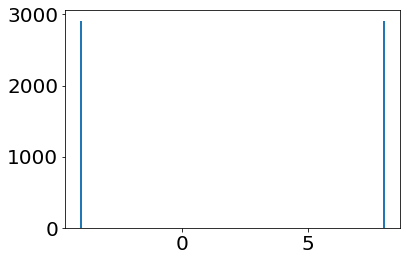

In [64]:
plt.hist(dt, bins=200)
plt.show()

In [59]:
for tile_id in mu3e_detector.TileDetector.tile:
    tile = mu3e_detector.TileDetector.tile[tile_id]
    #tile.dt_truth_abs = tile.dt_truth # + master_tile
    tile.dt_cal_abs += tile.dt_cal

In [60]:
for tile_id in mu3e_detector.TileDetector.tile:
    tile = mu3e_detector.TileDetector.tile[tile_id]
    tile.dt_truth -= tile.dt_cal # + master_tile
    tile.dt_cal = 0.

In [61]:
mu3e_detector.TileDetector.calibrated = False

# Generating Histograms

In [11]:
#options_hist = {
#    "histo_options": (40000, -20, 20),  # nbins, min, max (10000, -64, 64)
#    "hist_file": "hist_test_2.root",  # histogram save file
#    "ttree_loc": "mu3e"   # alignment/
#}

In [12]:
#melp.taft.generate_hist("../../Downloads/mu3e_sorted_000002.root", **options_hist)
#melp.taft.generate_hist("./merged.root", **options_hist)

# Calibrating Tile Detector

In [38]:
options_cal = {
    "debug_station": 1,     # 1 / 2
    "tof": "simple",  # advanced_new / advanced_graf / simple / None
    "dt_mode": "median",    # MEDIAN / mean / gaus
    "overwrite": True,      # True / False
    "hist_file": "/run/media/maximilian/Volume/merged.root", #'/home/maximilian/SSD/merged.root',  # "/run/media/maximilian/Volume/merged.root",
    
    "phi_penalties": [1,1,1], # neighboring loop,  column offset, measured offset
    #"z_penalties": [1,1], # neighboring loop,  measured offset
    
    "cosmic_correction": True,
    "cosmic_mc_primary": True,
    "cosmic_n_modes" : 5,  # (x2 for cos and sin)
    "ttree_loc": "alignment/mu3e",
    "cosmic_threshold": 0.05,  #m
    "cosmic_file": '/run/media/maximilian/Volume/Cosmics_Dev/mu3e_sorted_000011.root'
    #"cosmic_file": '/home/maximilian/mu3e_run_000779_cosmic_sorted.root'
    #'/home/maximilian/mu3e_run_000779_cosmic_sorted.root'# '/run/media/maximilian/Volume/mu3e_sorted_000002_cosmic.root' #'./cosmic_test.root'
}

In [39]:
resid_z, resid_phi, cal_z, cal_phi, popt_1, popt_2 = melp.taft.calibrate(**options_cal)

*Using dt mode:  median
*Simple correction phi (sum loop)
*Simple correction phi (sum loop)
*optimizing relative phi offsets
 Settings:
  -> Penalty for measured offset: 1
  -> Penalty for column offset: 1
  -> Penalty for neighboring loop: 1
*optimizing relative phi offsets
 Settings:
  -> Penalty for measured offset: 1
  -> Penalty for column offset: 1
  -> Penalty for neighboring loop: 1
*TOF correction
*TOF correction
*Calculating absolute timing offsets to master tile: 200000
*Calculating absolute timing offsets to master tile: 300000
*Two event correction
  ->  80  % | Total Frames:  499841
  -> Cosmic Muons:  374236
*Two event correction
  ->  80  % | Total Frames:  499841
  -> Cosmic Muons:  262453
Calibration finished
Elapsed time: 143.0558 seconds


/home/maximilian/Github/melp/melp/taft/calibrate.py:481: UserWarning: Warning: deprecated
  warnings.warn("Warning: deprecated")
/home/maximilian/Github/melp/melp/taft/calibrate.py:416: UserWarning: Warning: deprecated
  warnings.warn("Warning: deprecated")


In [65]:
mu3e_detector.save("22_iter3_phi_cosmic.taft")

In [41]:
resid_z = np.array(resid_z)
resid_phi = np.array(resid_phi)

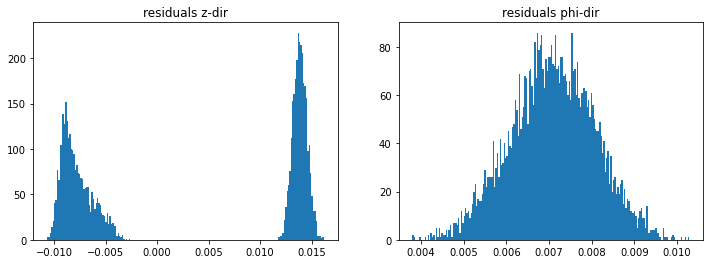

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(resid_z, bins=200)
axs[0].title.set_text("residuals z-dir")
axs[1].hist(resid_phi, bins=200)
axs[1].title.set_text("residuals phi-dir")
plt.show()

### small data sets results in empty histograms between some tiles
#### -> big jumps in dt

## Result for z-direction (station 1)

In [43]:
cal1 = {}
for phi_row in range(56):
    dt_truth = [0]
    for tile in range(0, 51):
        
        tile_id = 200000 + phi_row + tile * 56

        dt_tmp = (mu3e_detector.TileDetector.tile[tile_id].dt_truth -
                   mu3e_detector.TileDetector.tile[mu3e_detector.TileDetector.getNeighbour(tile_id, "right")].dt_truth)
        dt_truth.append(dt_truth[-1] + dt_tmp)

    cal1[phi_row] = np.array(dt_truth)

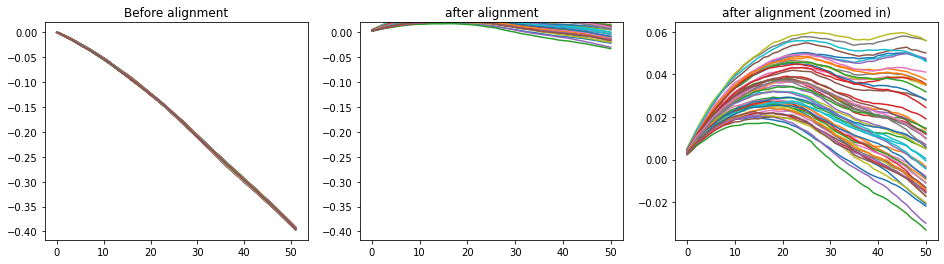

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

for phi in cal1:
    axs[0].plot(np.array(cal1[phi], dtype=object))

axs[0].autoscale()
axs[0].title.set_text("Before alignment")

for phi in cal_z:
    axs[1].plot(cal_z[phi])

axs[1].set_ylim(axs[0].get_ylim())
axs[1].title.set_text("after alignment")

for phi in cal_z:
    axs[2].plot(cal_z[phi])

axs[2].title.set_text("after alignment (zoomed in)")
plt.show()

## Result for phi-direction

In [45]:
cal2 = {}
for z_column in range(52):
    dt_truth = [0]
    for tile in range(0, 56):
        
        tile_id = (200000 + z_column*56 + tile)

        dt_tmp = (mu3e_detector.TileDetector.tile[tile_id].dt_truth -
                   mu3e_detector.TileDetector.tile[mu3e_detector.TileDetector.getNeighbour(tile_id, "up")].dt_truth)
        dt_truth.append(dt_truth[-1] + dt_tmp)

    cal2[z_column] = np.array(dt_truth)

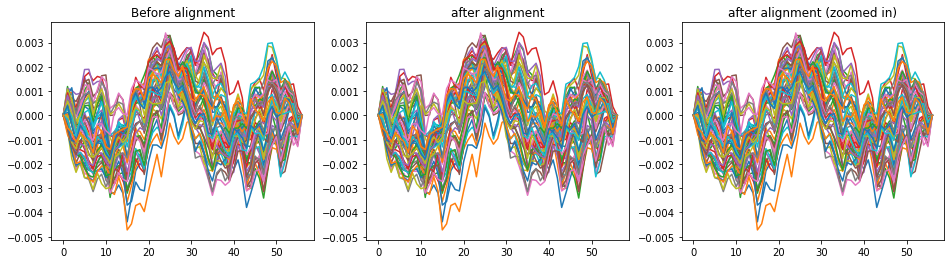

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

for phi in cal2:
    axs[0].plot(cal2[phi])

axs[0].autoscale()
axs[0].title.set_text("Before alignment")

for phi in cal_phi:
    axs[1].plot(cal_phi[phi])

axs[1].set_ylim(axs[0].get_ylim())
axs[1].title.set_text("after alignment")

for phi in cal_phi:
    axs[2].plot(cal_phi[phi])

axs[2].title.set_text("after alignment (zoomed in)")
plt.show()

# Calibrated station

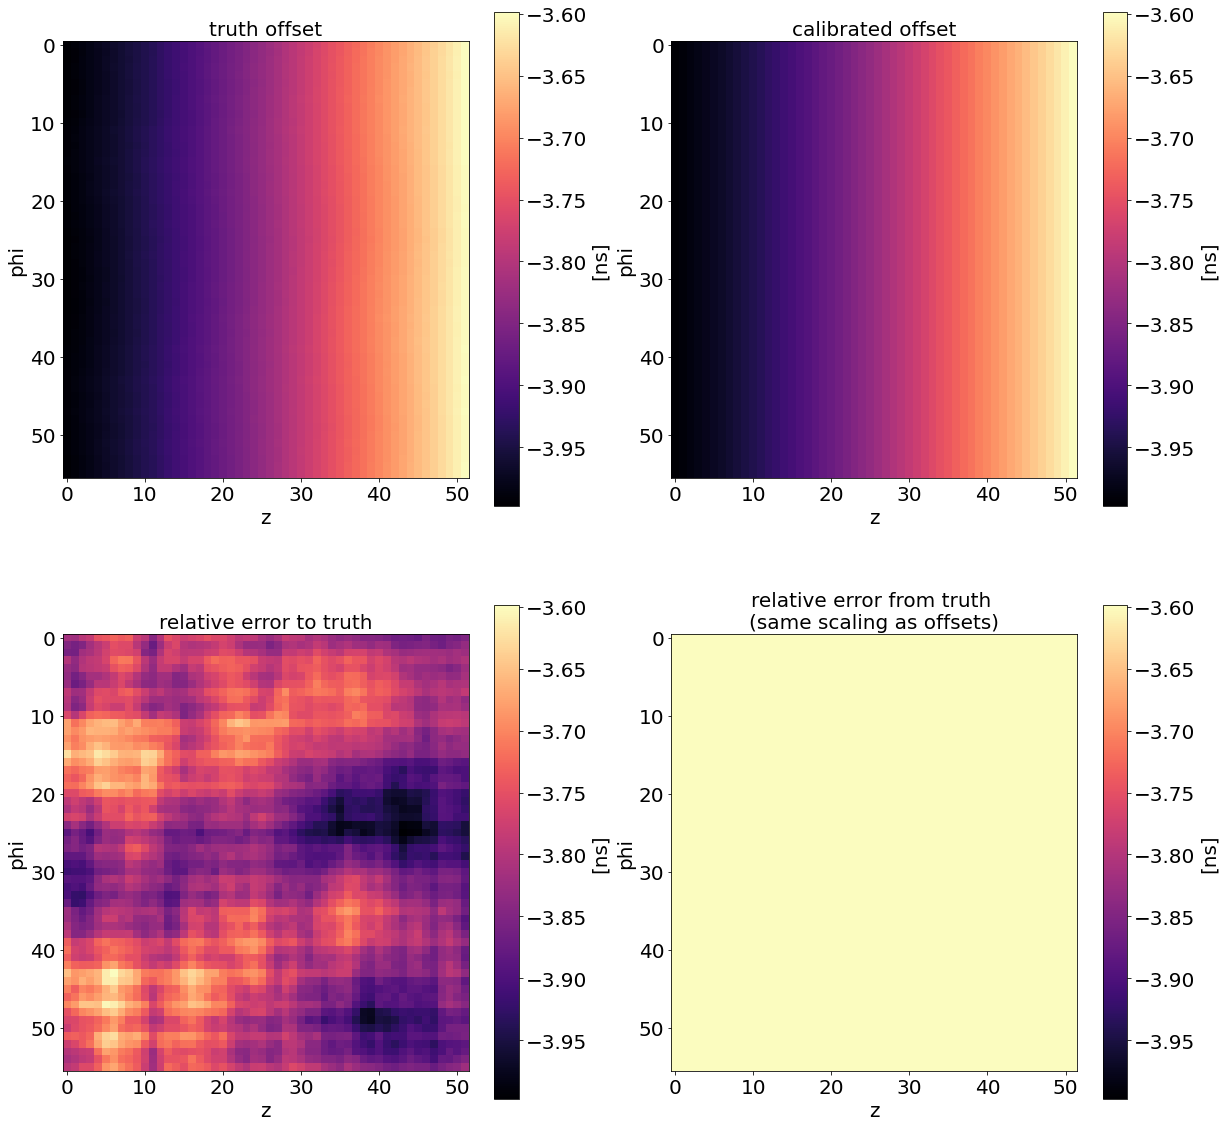

In [47]:
melp.taft.plot_station_calibration(mu3e_detector, 1)

In [48]:
#mu3e_detector.save("test_det.dev")

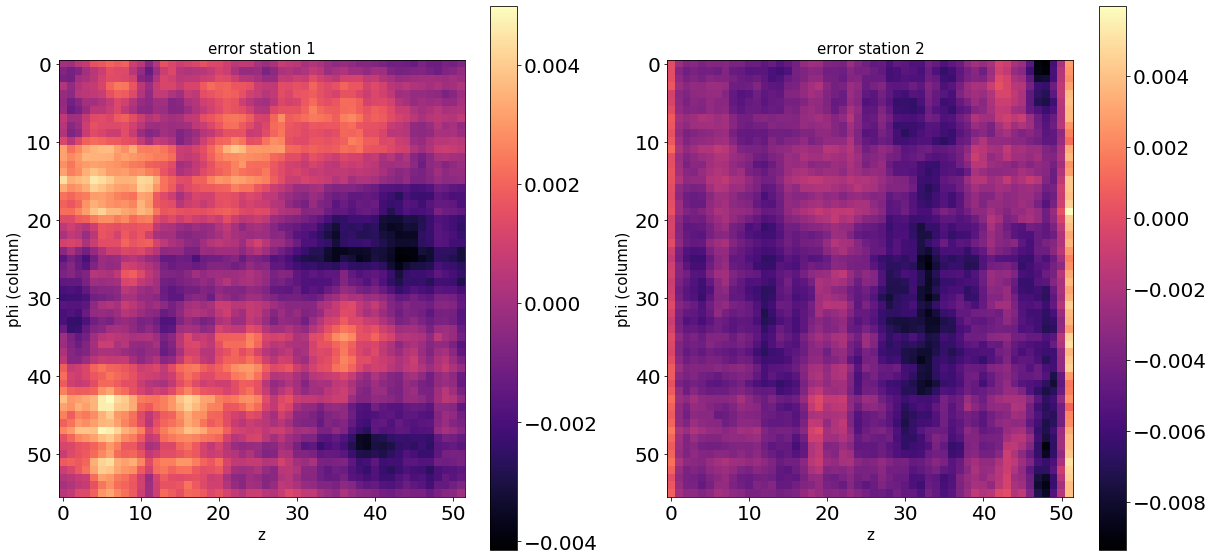

Station 1: max error:  0.00498  min error:  -0.00415
Station 2: max error:  0.00595  min error:  -0.00936


In [49]:
melp.taft.plot_calibration(mu3e_detector)

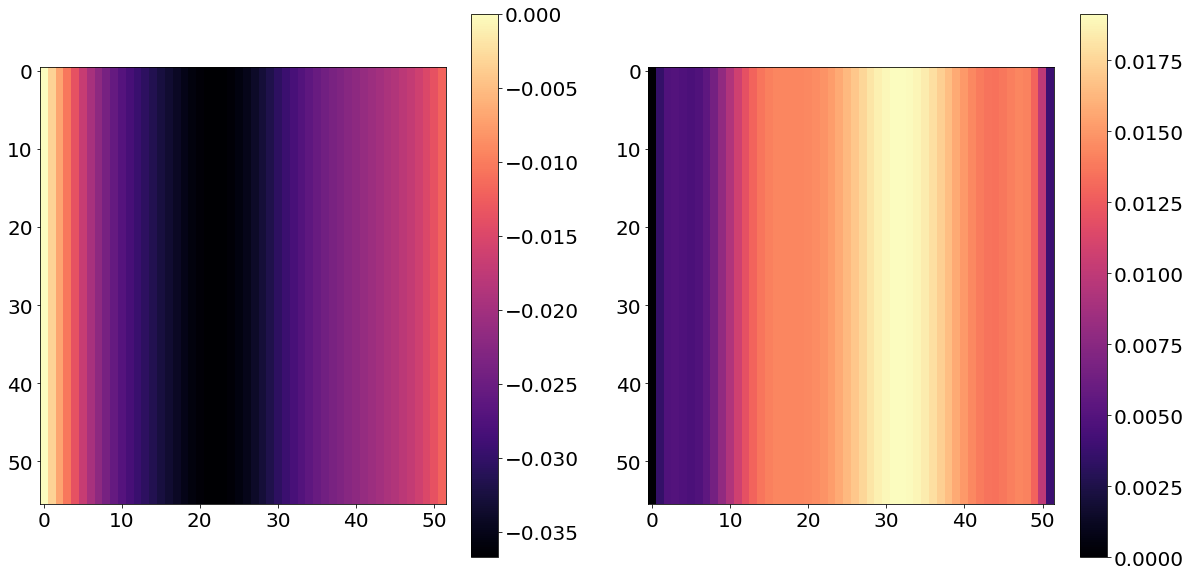

In [50]:
melp.taft.plot_correction_function(melp.taft.corrections.calibration_correction_z, popt_1, popt_2)

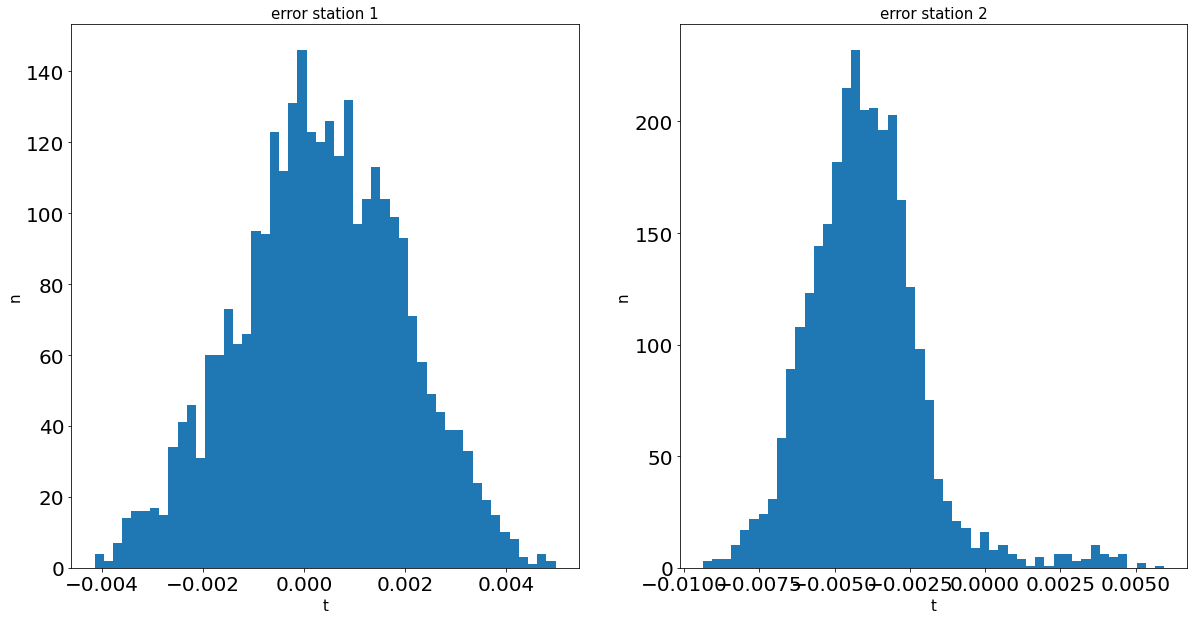

Station 1: max error:  0.00498  min error:  -0.00415
Station 2: max error:  0.00595  min error:  -0.00936


In [51]:
melp.taft.plot_error_dist(mu3e_detector)

## Testing section

In [52]:
hist = []

master_time = mu3e_detector.TileDetector.tile[200000].dt_truth
for tileid in mu3e_detector.TileDetector.tile:
    if tileid >= 300000:
        continue
    tile = mu3e_detector.TileDetector.tile[tileid]
    time_t = tile.dt_truth - master_time
    time_c = tile.dt_cal
    hist.append(time_t - time_c)

In [53]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

import scipy.optimize as opt

hist_1, bin_edges = np.histogram(hist, bins=150, range=(-0.007,0.007),  density=False)

bin_center = (bin_edges[1:] + bin_edges[:-1])/2
print(len(bin_center), "  |  ", len(bin_edges))

popt, cov = opt.curve_fit(gauss_function, bin_center, hist_1, p0=(60,0,0.001))

print('Mu: {0:.10f}'.format(popt[1]))
print('Sigma: {0:.10f}'.format(popt[2]))

150   |   151
Mu: 0.0003717204
Sigma: 0.0016646743


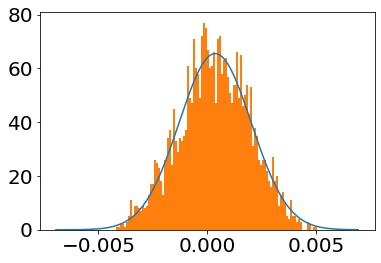

In [54]:
plt.plot(bin_center, gauss_function(bin_center, *popt))
plt.hist(hist, bins=150, range=(-0.007,0.007), density = False)
plt.show()

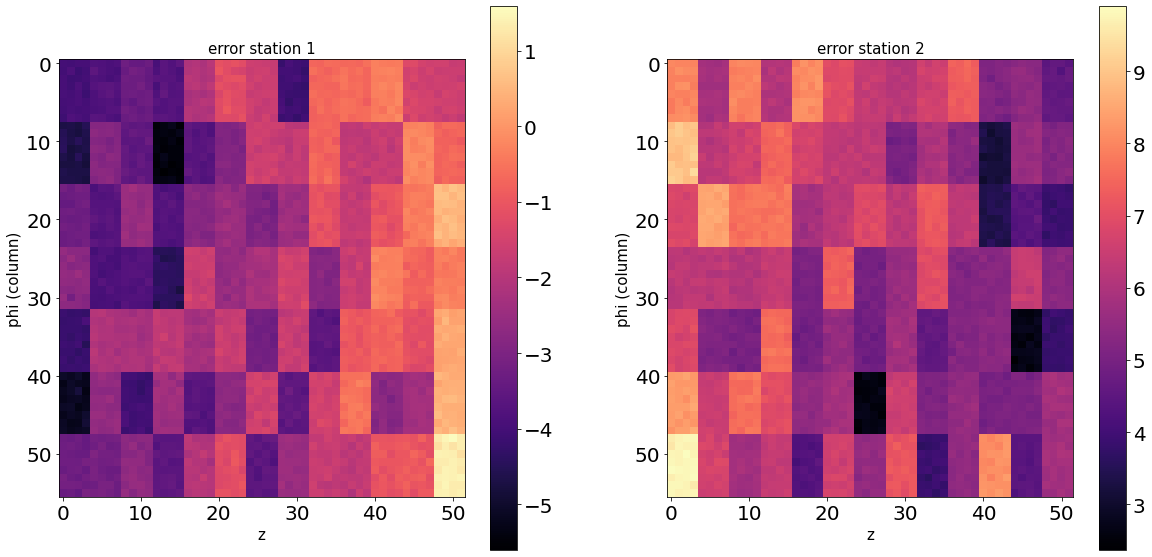

Station 1: max error:  1.59125  min error:  -5.60478
Station 2: max error:  9.90262  min error:  2.36831


In [55]:
melp.taft.plot_calibration_Abs(mu3e_detector)